<a href="https://colab.research.google.com/github/FrancescoZanni/MLPNS_FZanni/blob/main/NeuralNetworks/assess_TS_classification_w_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

THIS KERAS EXAMPLE OF APPLICATION OF TRANSFORMERS TO TIME SERIES ANALYSIS IS **WRONG**

My student Willow Fox Fortino found that out... 

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/MyDrive/MLPNS_2023/transformer

/content/drive/MyDrive/MLPNS_2023/transformer


In [4]:
import numpy as np
import matplotlib.pyplot as plt


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# TASK 1: 


(3601, 500, 1)
(3601, 500)


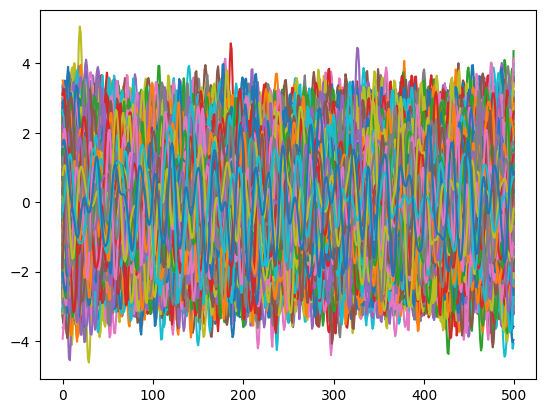

In [5]:
# plt.plot(x_train) non funziona, devo togliere la terza dimensione
print(x_train.shape)
print(x_train.reshape(3601,500).shape)
plt.plot(x_train.reshape(3601,500).T); #transpongo altrimenti mostra le time series sull'asse x e non il tempo 

Non è utile come visualizzazione, provo a plottarne poche 

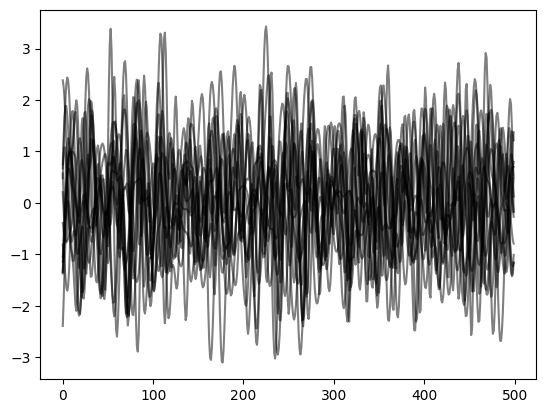

In [6]:
plt.plot(x_train.reshape(3601,500)[1:15,:].T, alpha=0.5, color="black");

Forse qualche outlier per il picco ma niente di ovvio anche qua.

ORA?


(-0.5, 1754.5, 499.5, -0.5)

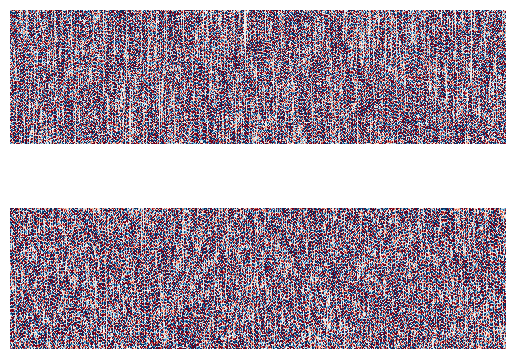

In [7]:
#Aggiunte Prof
#Visualizzo come heatmap
fig, ax = plt.subplots(2,1)
ax[0].imshow(x_train.reshape(3601,500)[y_train==0].T, 
             interpolation="nearest", clim=[-1,1], cmap="RdBu")

ax[1].imshow(x_train.reshape(3601,500)[y_train==1].T, 
             interpolation="nearest", clim=[-1,1], cmap="RdBu")

ax[0].axis("off")
ax[1].axis("off")




In questo modo visulaizzo una time series per riga, con il valore della time series sull'asse x.


Non osservo nessuna differenza evidente, non c'è struttura, anche questa visualizzazione non mi aiuta... 


Una cosa che vedo è che non ci sono outliers significativi, non devo togliere outliers troppo importanti che non mi permetterebbero di vedere un risultato


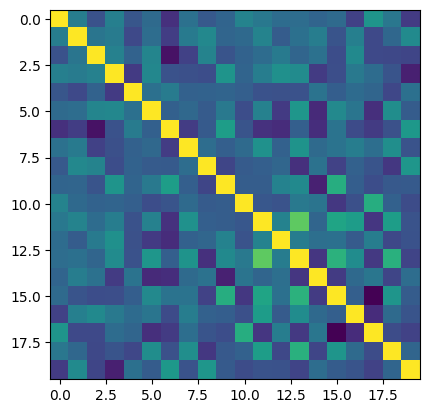

In [8]:
#Matrice di correlazione 

subset = np.concatenate([x_train.reshape(3601,500)[y_train==0][0:10].T,
                         x_train.reshape(3601,500)[y_train==1][0:10].T], axis=1)

plt.imshow(np.corrcoef(subset.T))

Se avessi una correlazione importante vedrei una matrice a blocchi, che in questo caso non osservo. 

Dopo questa esplorazione so che non posso usare modelli lineari perchè non funzionerebbero! non c'è una relazione semplice, quindi mi orienterò verso NNs o random forest.

Una cosa interessante potrebbe essere invece dei primi 10 prenderne 10 random e vedere cosa si osserva. 





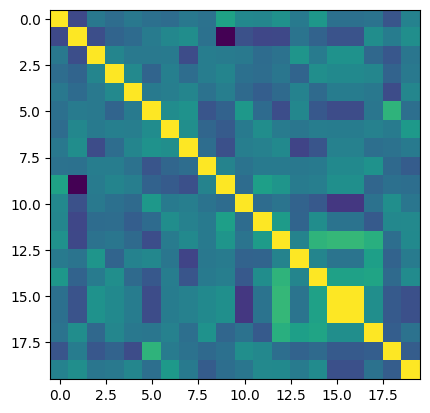

In [40]:
subset = np.concatenate([x_train.reshape(3601,500)[y_train==0][np.random.randint(0,500,10)].T,
                         x_train.reshape(3601,500)[y_train==1][np.random.randint(0,500,10)].T], axis=1)


plt.imshow(np.corrcoef(subset.T))

Qualcosa di diverso si vede ogni tanto ma non è una cosa ricorrente, quindi non mi preoccupa. 

Ci sono time series correlate ma non so quali e non hanno a che fare con la posizione nel dataset. 

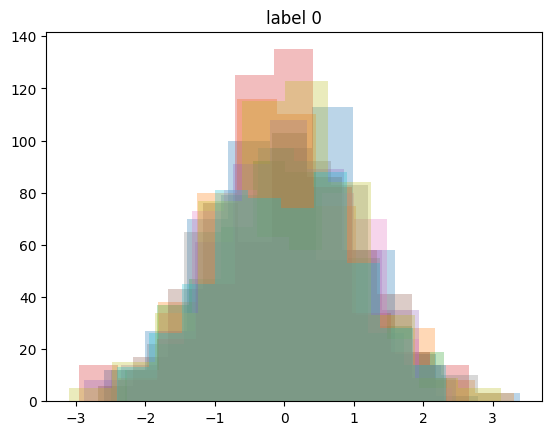

In [10]:
#Istogrammi
for i in range(10):
   plt.hist(x_train.reshape(3601,500)[y_train == 0][i].T, alpha=0.3)
   plt.title("label 0")

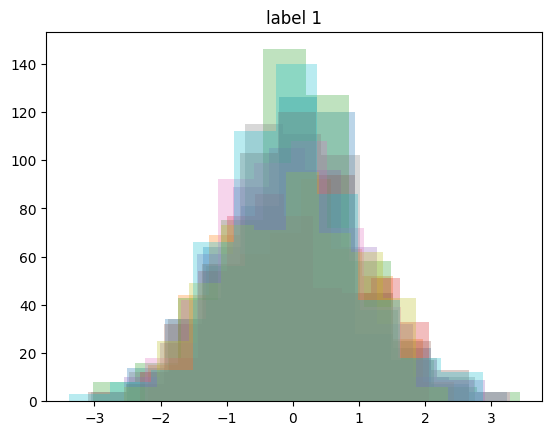

In [11]:
#Istogrammi
for i in range(10):
   plt.hist(x_train.reshape(3601,500)[y_train == 1][i].T, alpha=0.3)
   plt.title("label 1")

Comincio a vedere che potrebbero esserci differenze strutturali ma niente ancora di ovvio. 


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [13]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [14]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [15]:
input_shape = x_train.shape[1:]

"""
create a model with :
4 multiattention heads each size 256, 
4 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,            #size dei multiattention heads
    num_heads=4,              #numero di multiattention heads
    ff_dim=4,                 #4 neuroni nel convolutional layer (?)
    num_transformer_blocks=4, #numero di transformer blocks
    mlp_units=[128],          #Numero di neuroni nel MLP
    mlp_dropout=0.4,          #40% di dropout nel transformer per evitare overfitting
    dropout=0.25,             #25% nel feed forward
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

#model = keras.models.load_model('transformer_h4_model.h5')
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]
#non viene specificato su cosa attivare la callback, di default va sulla loss function



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [91]:
import pickle
with open('transformer_h4_history', "rb") as file_pi:
    history_4h = pickle.load(file_pi)
   

In [17]:
history_4h.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

Text(0, 0.5, 'Accuracy')

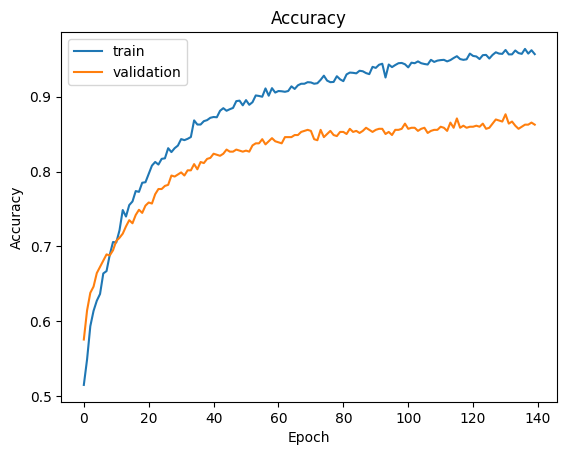

In [48]:
plt.plot(history_4h["sparse_categorical_accuracy"], label= "train")
plt.plot(history_4h["val_sparse_categorical_accuracy"], label = "validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Significativo overfitting!

Text(0, 0.5, 'Loss')

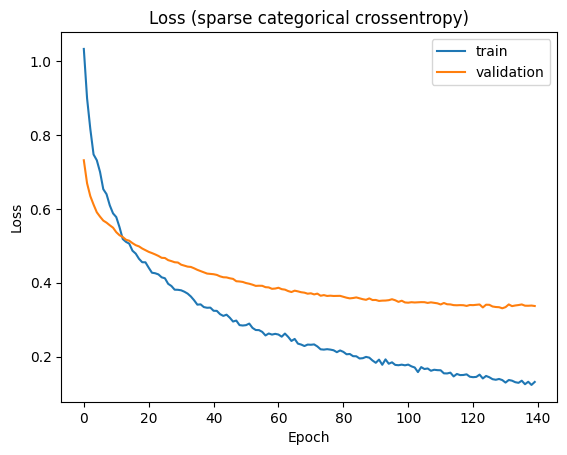

In [49]:
plt.plot(history_4h["loss"], label= "train")
plt.plot(history_4h["val_loss"], label = "validation")
plt.legend()
plt.title("Loss (sparse categorical crossentropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Anche qua molto overfitting!

In [69]:
print("Training accuracy: {:.3f}".format(history_4h["sparse_categorical_accuracy"][len(history_4h["sparse_categorical_accuracy"])-1]))
print("Validation Accuracy: {:.3f}".format(history_4h["val_sparse_categorical_accuracy"][len(history_4h["val_sparse_categorical_accuracy"])-1]))

Training accuracy: 0.957
Validation Accuracy: 0.863


## Conclusions

Official version: In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).

**Reality** these transformer blocks are not doing anything! 
- there is no positional encoding
- the time series are 1D and its not clear that the performance holds going from multivariate (tockenized) to univariate


In [79]:
input_shape = x_train.shape[1:]

"""
create another model with :
1 multiattention head size 256, 
0 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model_noAtt = build_model(
    input_shape,
    head_size=256,            #size dei multiattention heads
    num_heads=1,              #numero di multiattention heads
    ff_dim=4,                 #4 neuroni nel convolutional layer (?)
    num_transformer_blocks=0, #numero di transformer blocks
    mlp_units=[128],          #Numero di neuroni nel MLP
    mlp_dropout=0.4,          #40% di dropout nel transformer per evitare overfitting
    dropout=0.25,             #25% nel feed forward
)

model_noAtt.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

#model = keras.models.load_model('transformer_h4_model.h5')


callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True,monitor = "loss") ]
#non viene specificato su cosa attivare la callback, di default va sulla loss function

model_noAtt.summary()

   

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 global_average_pooling1d_6   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               64128     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                                 
Total params: 64,386
Trainable params: 64,386
Non-trainable params: 0
_______________________________________________________

print accuracy and loss

plot the history .... what do you see?

In [81]:
history_noAtt = model_noAtt.fit(x_train,y_train,callbacks=callbacks,epochs = 10000, validation_data = [x_test,y_test], batch_size=16)

Epoch 1/10000
226/226 [==============================] - 1s 6ms/step - loss: 0.7532 - sparse_categorical_accuracy: 0.6182 - val_loss: 0.5987 - val_sparse_categorical_accuracy: 0.6765
Epoch 2/10000
226/226 [==============================] - 1s 4ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.6543 - val_loss: 0.5636 - val_sparse_categorical_accuracy: 0.7114
Epoch 3/10000
226/226 [==============================] - 1s 3ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.5367 - val_sparse_categorical_accuracy: 0.7280
Epoch 4/10000
226/226 [==============================] - 1s 4ms/step - loss: 0.6081 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.5195 - val_sparse_categorical_accuracy: 0.7447
Epoch 5/10000
226/226 [==============================] - 1s 4ms/step - loss: 0.5605 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.7606
Epoch 6/10000
226/226 [==============================] - 1s 4ms/step - loss: 0.5419 -

Text(0, 0.5, 'Accuracy')

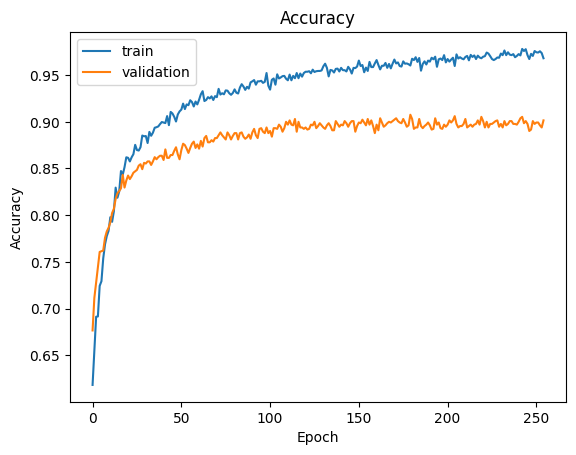

In [87]:
plt.plot(history_noAtt.history["sparse_categorical_accuracy"], label= "train")
plt.plot(history_noAtt.history["val_sparse_categorical_accuracy"], label = "validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

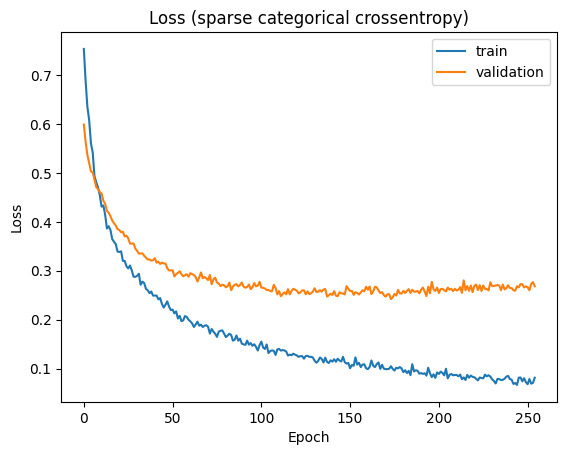

In [88]:
plt.plot(history_noAtt.history["loss"], label= "train")
plt.plot(history_noAtt.history["val_loss"], label = "validation")
plt.legend()
plt.title("Loss (sparse categorical crossentropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [89]:
print("Training accuracy: {:.3f}".format(history_noAtt.history["sparse_categorical_accuracy"][len(history_noAtt.history["sparse_categorical_accuracy"])-1]))
print("Validation Accuracy: {:.3f}".format(history_noAtt.history["val_sparse_categorical_accuracy"][len(history_noAtt.history["val_sparse_categorical_accuracy"])-1]))

Training accuracy: 0.968
Validation Accuracy: 0.902


#conclusione
Non si osserva un peggioramento di prestazioni rimuovendo completamente i blocchi di attenzione e di encoding, ovvero usando un feed forward NN. 

Anzi al contrario l'accuracy per il validation set è migliorata. 

Il motivo dell'inutilità dell'attenzion, come visto durante la lezione sta nell'assenza di positional encoding! 

Tuttavia l'overfitting rimane significativo

##Modello Prof<

In [92]:
with open('transformer_h1_history', "rb") as file_pi:
    history_1h = pickle.load(file_pi)

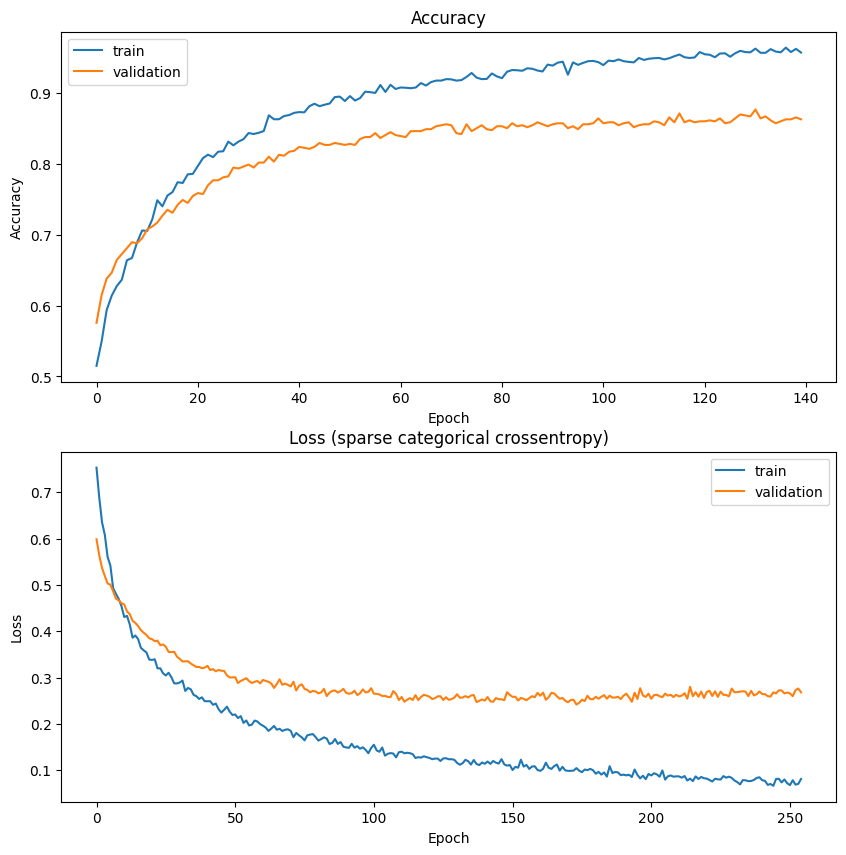

In [110]:

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(history_1h["sparse_categorical_accuracy"], label= "train")
ax1.plot(history_1h["val_sparse_categorical_accuracy"], label = "validation")
ax1.legend()
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


ax2.plot(history_noAtt.history["loss"], label= "train")
ax2.plot(history_noAtt.history["val_loss"], label = "validation")
ax2.legend()
ax2.set_title("Loss (sparse categorical crossentropy)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss");